In [2]:
# Device and Events Simulation + Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Generate 100 Devices
# -------------------------------

def generate_devices(num_devices=100):
    manufacturers = ["Cisco", "Juniper", "HP", "Dell", "Palo Alto"]
    organizations = [(101, "Org A"), (102, "Org B"), (103, "Org C")]

    devices = []
    for i in range(1, num_devices + 1):
        org = random.choice(organizations)
        device = {
            "device_id": i,
            "device_name": f"Device_{i}",
            "device_ip": f"192.168.{i//256}.{i%256}",
            "organization_id": org[0],
            "organization_name": org[1],
            "device_description": f"Device number {i} in the system.",
            "device_manufacturer": random.choice(manufacturers),
            "device_serial_number": f"SN-{100000 + i}"
        }
        devices.append(device)
    return devices

devices = generate_devices()
df_devices = pd.DataFrame(devices)
df_devices.head()


,device_id,device_name,device_ip,organization_id,organization_name,device_description,device_manufacturer,device_serial_number
0,1,Device_1,192.168.0.1,101,Org A,Device number 1 in the system.,Juniper,SN-100001
1,2,Device_2,192.168.0.2,103,Org C,Device number 2 in the system.,Juniper,SN-100002
2,3,Device_3,192.168.0.3,102,Org B,Device number 3 in the system.,Cisco,SN-100003
3,4,Device_4,192.168.0.4,103,Org C,Device number 4 in the system.,Juniper,SN-100004
4,5,Device_5,192.168.0.5,103,Org C,Device number 5 in the system.,HP,SN-100005


In [13]:
# -------------------------------
# 2. Generate 1000 Events
# -------------------------------

def generate_events(devices, num_events=1000):
    events = []
    start_time = datetime.now() - timedelta(hours=2)
    event_types = ["info", "warning", "error", "critical"]

    for i in range(1, num_events + 1):
        device = random.choice(devices)
        timestamp = start_time + timedelta(seconds=random.randint(0, 7200))
        event = {
            "event_id": i,
            "event_description": f"Event {i} for device {device['device_name']}",
            "device_id": device["device_id"],
            "event_type": random.choice(event_types),
            "event_timestamp": timestamp
        }
        events.append(event)
    return events

events = generate_events(devices)
df_events = pd.DataFrame(events)
df_events['event_timestamp'] = pd.to_datetime(df_events['event_timestamp'])
df_events = df_events.sort_values(by='event_timestamp')


,event_id,event_description,device_id,event_type,event_timestamp
954,955,Event 955 for device Device_33,33,error,2025-08-14 11:34:34.742607
457,458,Event 458 for device Device_21,21,error,2025-08-14 11:35:14.742607
853,854,Event 854 for device Device_67,67,error,2025-08-14 11:35:17.742607
751,752,Event 752 for device Device_37,37,info,2025-08-14 11:35:18.742607
216,217,Event 217 for device Device_79,79,warning,2025-08-14 11:35:21.742607


Index(['event_id', 'event_description', 'device_id', 'event_type'], dtype='object')
[44, 16, 5, 29, 61, 60, 79, 35, 80, 55, 89, 41, 98, 17, 22, 36, 48, 72, 21, 20]


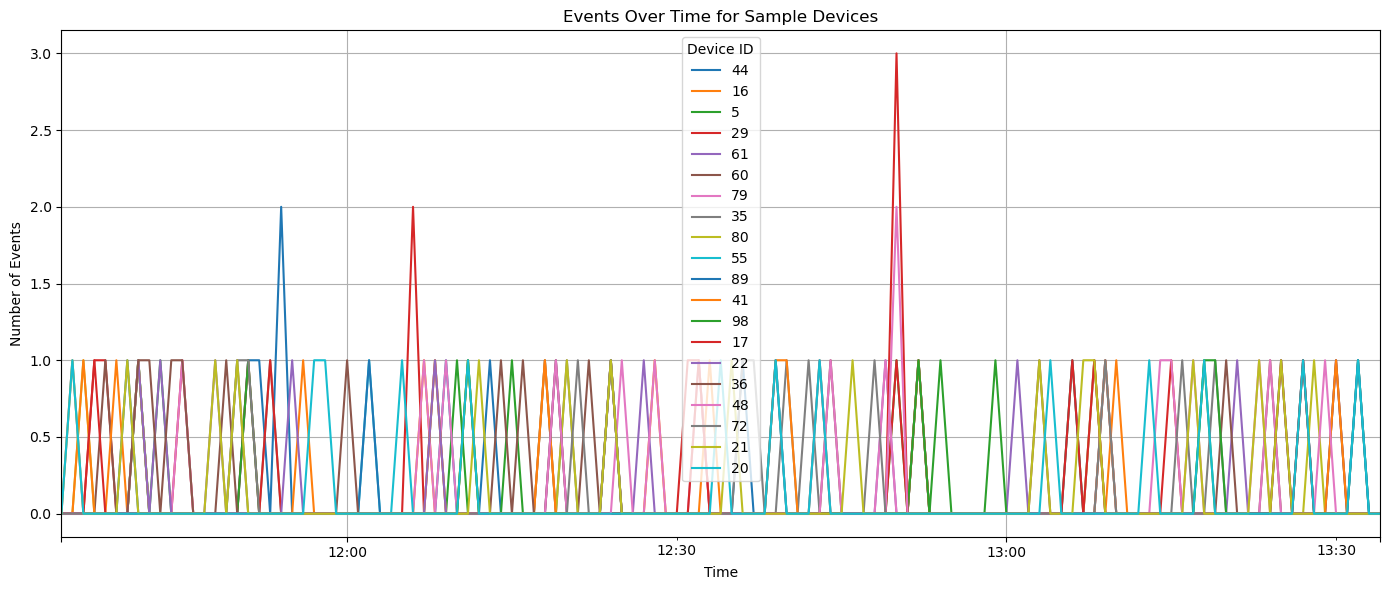

In [32]:
# -------------------------------
# 3. Time-based Analysis
# -------------------------------


# Check if event_timestamp is in index
if 'event_timestamp' not in df_events.columns:
    df_events.reset_index(inplace=True)

# Group events per 1-minute interval per device
grouped = df_events.groupby(['device_id']).resample('1min').size().unstack(level=0).fillna(0)

# Plot events over time for a few devices
sample_devices = df_devices.sample(20)['device_id'].tolist()
print(sample_devices)
grouped[sample_devices].plot(figsize=(14,6), title="Events Over Time for Sample Devices")
plt.xlabel("Time")
plt.ylabel("Number of Events")
plt.legend(title="Device ID")
plt.grid(True)
plt.tight_layout()
plt.show()


Running prediction for Device ID: 48


C:\Users\DEANESH\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


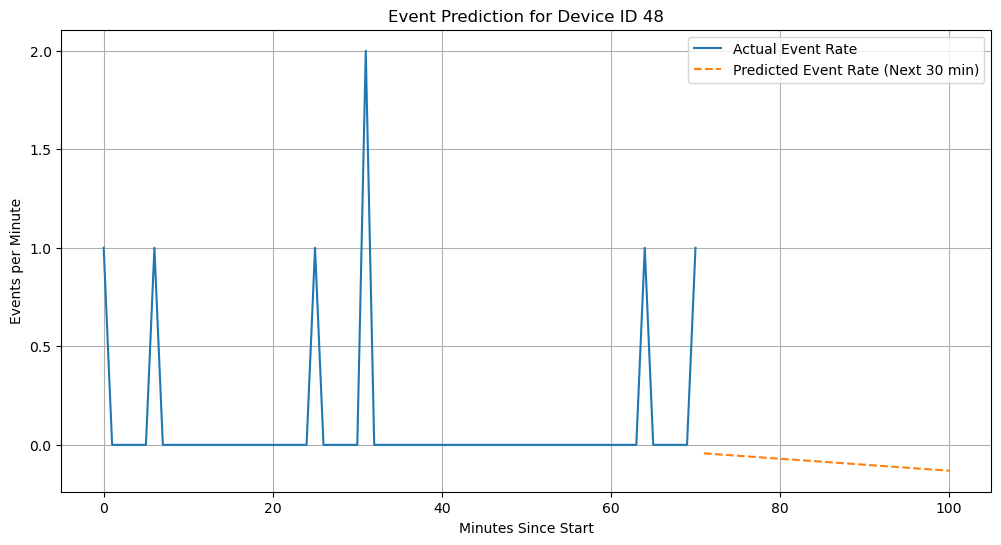

In [29]:
# -------------------------------
# 4. Predictive Analysis (Simple)
# -------------------------------

# Choose a single device for prediction
device_id = random.choice(df_devices['device_id'].tolist())
print(f"Running prediction for Device ID: {device_id}")

# Resample per minute
device_events = df_events[df_events['device_id'] == device_id].resample('1min').size().reset_index(name='event_count')
device_events = device_events.set_index('event_timestamp').resample('1min').sum().fillna(0).reset_index()

# Create time feature
device_events['minutes_since_start'] = (device_events['event_timestamp'] - device_events['event_timestamp'].min()).dt.total_seconds() / 60

# Prepare data
X = device_events[['minutes_since_start']]
y = device_events['event_count']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict Next 30 Minutes
future_minutes = np.arange(X['minutes_since_start'].max() + 1, X['minutes_since_start'].max() + 31).reshape(-1, 1)
future_preds = model.predict(future_minutes)

# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(X['minutes_since_start'], y, label='Actual Event Rate')
plt.plot(future_minutes, future_preds, label='Predicted Event Rate (Next 30 min)', linestyle='--')
plt.title(f"Event Prediction for Device ID {device_id}")
plt.xlabel("Minutes Since Start")
plt.ylabel("Events per Minute")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
def chunk_list(lst, chunk_size):
    """Split list into chunks of size chunk_size."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

chunk_size = 15
my_list = list(range(1, 102))  # List of 100 numbers: [1, 2, ..., 100]

chunks = list(chunk_list(my_list, chunk_size))  # Split into 10 chunks of 10 items each

for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}: {chunk}")

Chunk 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Chunk 2: [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Chunk 3: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Chunk 4: [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Chunk 5: [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
Chunk 6: [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
Chunk 7: [91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
